In [1]:
import os
import numpy as np
import pandas as pd
import json
import itertools
import pickle
import matplotlib.pyplot as plt
import torch
from sentence_transformers import SentenceTransformer, util

## Prepare data

### Selecte data relevant to federal races

In [7]:
source_path = '../../../fb_2022'

In [8]:
var = pd.read_csv(os.path.join(source_path, 'fb_2022_adid_var_sets_072124.csv.gz'))

/tmp/ipykernel_25901/1101205232.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  var = pd.read_csv(os.path.join(source_path, 'fb_2022_adid_var_sets_072124.csv.gz'))


In [4]:
var.columns

Index(['ad_id', 'page_id', 'ad_creation_time', 'ad_delivery_start_time',
       'ad_delivery_stop_time', 'spend', 'impressions', 'region_distribution',
       'demographic_distribution', 'publisher_platforms', 'potential_reach',
       'from_pd_id', 'wmp_media_type', 'aws_face_vid', 'aws_face_img',
       'sub_bucket', 'race_of_focus', 'race_of_focus_region_pct',
       'ad_tone_constructed', 'ad_tone_mentionbased', 'goal_DONATE_prediction',
       'goal_DONATE_predicted_prob', 'goal_CONTACT_prediction',
       'goal_CONTACT_predicted_prob', 'goal_PURCHASE_prediction',
       'goal_PURCHASE_predicted_prob', 'goal_GOTV_prediction',
       'goal_GOTV_predicted_prob', 'goal_EVENT_prediction',
       'goal_EVENT_predicted_prob', 'goal_POLL_prediction',
       'goal_POLL_predicted_prob', 'goal_GATHERINFO_prediction',
       'goal_GATHERINFO_predicted_prob', 'goal_LEARNMORE_prediction',
       'goal_LEARNMORE_predicted_prob', 'goal_PRIMARY_PERSUADE_prediction',
       'goal_PRIMARY_PERSUADE_

In [9]:
'''
Filter for Set 3
'''
var = var[var.set3 == 1]

In [6]:
var.shape

(123991, 73)

In [8]:
var[~var.race_of_focus.isin(['No race of focus', 'Downballot'])].sub_bucket.unique()

array(['3.1', '3.2.2.2', '3.2.2.1', '1'], dtype=object)

In [9]:
'''
Only house/senate races 
'''
condition = (var.wmp_office.isin(['us senate', 'us house'])) | (~var.race_of_focus.isin(['No race of focus', 'Downballot']))

In [10]:
var = var[condition]

In [11]:
var.shape

(96525, 73)

In [16]:
var.groupby(['wmp_spontype']).size()

wmp_spontype
campaign               53043
coordinated              343
down ballot                1
government agency        357
government official      842
group                  28495
party                   3105
party national          3613
dtype: int64

In [10]:
'''
Merge with text and cid mapping tables
'''
cid = pd.read_csv(os.path.join(source_path, 'cid_fb2022.csv'))
text = pd.read_csv(os.path.join(source_path, 'fb_2022_adid_text.csv.gz'))

In [11]:
var = var.merge(text, how='left', on='ad_id')

In [19]:
var = var.merge(cid, how='left', on='ad_id')

In [20]:
var[pd.isna(var.federal_cd)].shape

(355, 94)

In [22]:
'''
Drop clearly non-federal race spnosors
'''
var = var[var.wmp_spontype!= 'down ballot']

### Aggregate data at sponsor-media level

#### Federal candidates

In [24]:
var_cand = var[var.federal_cd==1]

In [25]:
cols = ['pd_id', 'wmp_media_type', 'cid']

In [26]:
# Aggregate by pdid AND media type
cand_sponsor_agg = var_cand[cols].groupby(cols).first().reset_index().groupby(['pd_id', 'wmp_media_type']).agg(lambda x: ' '.join(x)).reset_index()

In [27]:
cand_sponsor_agg.head(2)

,pd_id,wmp_media_type,cid
0,pd-1000253160054572-3,image,cid_106784 cid_108932 cid_108933 cid_85818 cid...
1,pd-1000253160054572-3,video,cid_108054 cid_108055 cid_85825


In [28]:
cand_sponsor_agg['num_unique'] = cand_sponsor_agg.cid.apply(lambda x: len(x.split()))

In [29]:
cand_sponsor_agg = cand_sponsor_agg[cand_sponsor_agg.num_unique > 1]

In [30]:
var_cand.wmp_spontype.unique()

array(['campaign'], dtype=object)

#### Non-campaign sponsors: Advertiser-media-race_of_focuse-level aggregation

In [31]:
var[var.federal_cd == 0].wmp_spontype.unique()

array(['government agency', 'group', nan, 'campaign',
       'government official', 'party national', 'party', 'coordinated'],
      dtype=object)

In [32]:
var[var.federal_cd == 0].wmp_office.unique()

array([nan, 'down ballot', 'us house', 'ballot measure',
       'us senate - other cycle', 'us senate',
       'us house - not in our 2022 FEC cd file',
       'president - other cycle', 'us house - other cycle', 'governor',
       'election outside US or in US comm/territory'], dtype=object)

In [33]:
'''
filter irrelevant offices among non-campaign sponsors
'''
irrelevant_offices = ['us house - other cycle', 'us senate - other cycle', 'down ballot', 
 'president - other cycle', 'ballot measure', 'election outside US or in US comm/territory', 'governor']
condition3 = (var.federal_cd == 0) & (~var.wmp_office.isin(irrelevant_offices))

var_noncand = var[condition3]

In [ ]:
# var_noncand[var.wmp_spontype == 'government agency'][['race_of_focus', 'advertiser_name', 'ad_type']]

In [34]:
'''
Remove those with no race of focus identified
'''
var_noncand = var_noncand[~pd.isna(var_noncand.race_of_focus)]
var_noncand = var_noncand[var_noncand.race_of_focus != 'No race of focus']

In [93]:
var_noncand.shape

(39346, 92)

In [35]:
'''
Aggregate at sponsor-media-race level
'''
cols2 = ['pd_id', 'cid', 'race_of_focus', 'wmp_media_type']

In [36]:
'''
Agg by pdid AND media type AND race of focus
'''
noncand_sponsor_agg = var_noncand[cols2].groupby(['pd_id', 'cid', 'race_of_focus']).first().reset_index()\
.groupby(['pd_id', 'race_of_focus', 'wmp_media_type']).agg(lambda x: ' '.join(x)).reset_index()

In [38]:
noncand_sponsor_agg.head(2)

,pd_id,race_of_focus,wmp_media_type,cid
0,pd-100053898949-2,CA11,image,cid_127823 cid_66514
1,pd-100053898949-2,IN08,image,cid_130676


In [39]:
noncand_sponsor_agg['num_unique'] = noncand_sponsor_agg.cid.apply(lambda x: len(x.split()))

# filter for sponsors with at least a pair of unique creatives
noncand_sponsor_agg = noncand_sponsor_agg[noncand_sponsor_agg.num_unique > 1]

In [40]:
noncand_sponsor_agg.shape

(3482, 5)

### Import trained corpous embedding and compute average similarity

In [16]:
corpus_embeddings = torch.load('../input_data/corpus_embedding_fb2022_uni.pt', map_location=torch.device('cpu'))

In [42]:
corpus_embeddings.shape
# corpus embedding index aligned with ascending cid index starting from 0 

torch.Size([153952, 384])

In [43]:
def compute_avg_similarity(cid_lst):
    cid_lst = cid_lst.split()
    
    pairs = list(itertools.combinations(cid_lst, 2))
    if pairs:
        scores = []
        for pair in pairs: 
            cid1, cid2 = pair
            idx1 = int(cid1.lstrip('cid_'))
            idx2 = int(cid2.lstrip('cid_'))
            
            score = util.cos_sim(corpus_embeddings[idx1], corpus_embeddings[idx2])[0][0].numpy()
            scores.append(score)
        return np.array(scores).mean(), np.array(scores).std()
    return None

### Federal candidates: by advertiser and media type¶

In [44]:
cand_sponsor_agg.loc[:, ['avg', 'std']] = cand_sponsor_agg.cid.apply(lambda x: pd.Series(compute_avg_similarity(x), index=['avg', 'std'], dtype="float"))

In [45]:
cand_sponsor_agg.head(4)

,pd_id,wmp_media_type,cid,num_unique,avg,std
0,pd-1000253160054572-3,image,cid_106784 cid_108932 cid_108933 cid_85818 cid...,7,0.679787,0.221322
1,pd-1000253160054572-3,video,cid_108054 cid_108055 cid_85825,3,0.939069,0.043084
2,pd-100112769260413-1,image,cid_118994 cid_29989 cid_61946 cid_67361 cid_7...,7,0.563807,0.086565
3,pd-100112769260413-1,video,cid_122019 cid_81062,2,0.584833,0.000000


In [46]:
'''
Candidates only
'''

cand_sponsor_agg.to_csv('../output_data/fb_set3_cand_pdid_media_average_pairwise_similarity.csv', index=False)

### non-campaign candidate sponsors: by sponsor - media - race of focus


In [47]:
noncand_sponsor_agg.loc[:, ['avg', 'std']] = noncand_sponsor_agg.cid.apply(lambda x: pd.Series(compute_avg_similarity(x), index=['avg', 'std'], dtype="float"))

In [48]:
'''
Got the final avg text similarity of noncandidates grouped by race of focus average pairwise similarity
'''
noncand_sponsor_agg.to_csv('../output_data/fb_set3_noncandidate_pdid_racefocus_media_average_pairwise_similarity.csv', index=False)

## Distribution of average text similarity exploration - legacy code
case studies on specific candidates

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
cand_sponsor_agg = pd.read_csv('../output_data/fb_set3_cand_pdid_media_average_pairwise_similarity.csv')

In [4]:
cand_sponsor_agg

,pd_id,wmp_media_type,cid,num_unique,avg,std
0,pd-1000253160054572-3,image,cid_106784 cid_108932 cid_108933 cid_85818 cid...,7,0.679787,0.221322
1,pd-1000253160054572-3,video,cid_108054 cid_108055 cid_85825,3,0.939069,0.043084
2,pd-100112769260413-1,image,cid_118994 cid_29989 cid_61946 cid_67361 cid_7...,7,0.563807,0.086565
3,pd-100112769260413-1,video,cid_122019 cid_81062,2,0.584833,0.000000
4,pd-100120696136353-1,image,cid_28378 cid_28379 cid_28380 cid_28381 cid_28...,14,0.632466,0.120565
...,...,...,...,...,...,...
1006,pd-969290446435504-4,video,cid_127287 cid_127288 cid_30518 cid_51937 cid_...,8,0.628641,0.091630
1007,pd-981697915185101-1,image,cid_33535 cid_33539,2,0.883669,0.000000
1008,pd-981697915185101-1,video,cid_33536 cid_33537 cid_33538,3,0.873036,0.019579
1009,pd-983573491675080-2,image,cid_47937 cid_47938 cid_47939 cid_47940 cid_47...,8,0.726048,0.055234


In [29]:
'''
Candidates: Sample means: video and image
'''
print(cand_sponsor_agg[cand_sponsor_agg.wmp_media_type == 'image'].avg.mean())
print(cand_sponsor_agg[cand_sponsor_agg.wmp_media_type == 'video'].avg.mean())

0.7100108097637853
0.6999514889935334


In [30]:
df = pd.read_csv('../input_data/fb_regression_table_for_descriptives.csv')

In [35]:
print(df[df.image == 1].AverageSimilarity.mean())
print(df[df.image == 0].AverageSimilarity.mean())

0.8038659324020984
0.8040340769036514


In [5]:
def compute_pairwise_similarity(df, pdid, media_type):
    
    cid_lst= df[(df.pd_id == pdid) & (df.wmp_media_type == media_type)].cid.iloc[0]
    
    cid_lst = cid_lst.split()
    
    pairs = list(itertools.combinations(cid_lst, 2))
    
    if pairs:
        scores = []
        for pair in pairs: 
            cid1, cid2 = pair
            idx1 = int(cid1.lstrip('cid_'))
            idx2 = int(cid2.lstrip('cid_'))
            
            score = util.cos_sim(corpus_embeddings[idx1], corpus_embeddings[idx2])[0][0].numpy()
            scores.append(float(score))
        return scores
    return None

In [ ]:
# var[var.pd_id == 'pd-1316372698453411-2'].disclaimer

In [17]:
aoc_vid = compute_pairwise_similarity(cand_sponsor_agg, 'pd-1316372698453411-2', 'video')
aoc_img = compute_pairwise_similarity(cand_sponsor_agg, 'pd-1316372698453411-2', 'image')

In [21]:
np.mean(aoc_vid)

0.6537002781644846

[Text(0.5, 1.0, 'Pairwise text similarity distribution (image): Alexandria Ocasio-Cortez'),
 Text(0.5, 0, 'similarity score')]

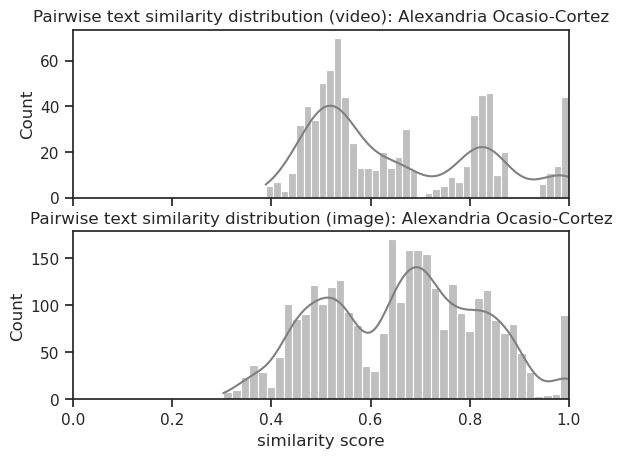

In [18]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(aoc_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(aoc_img, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Alexandria Ocasio-Cortez', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (image): Alexandria Ocasio-Cortez', xlabel='similarity score')

In [23]:
# Raphael Warnock
warnock_vid = compute_pairwise_similarity(cand_sponsor_agg, 'pd-109111900634787-2', 'video')
warnock_img = compute_pairwise_similarity(cand_sponsor_agg, 'pd-109111900634787-2', 'image')

In [24]:
np.array(warnock_vid).mean()

0.5910053199547307

In [25]:
np.array(warnock_img).mean()

0.6945312327326654

In [13]:
stats.mode(np.array(warnock_vid))

ModeResult(mode=0.5857389569282532, count=9)

In [14]:
stats.mode(np.array(warnock_img))

ModeResult(mode=0.8030939102172852, count=8)

[Text(0.5, 1.0, 'Pairwise text similarity distribution (image): Raphael Warnock'),
 Text(0.5, 0, 'similarity score')]

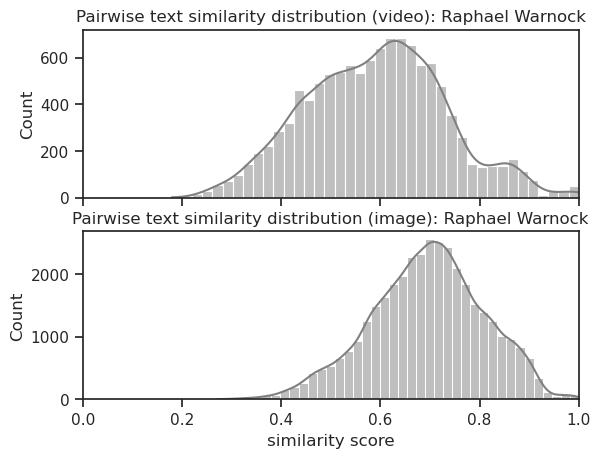

In [26]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(warnock_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(warnock_img, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Raphael Warnock', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (image): Raphael Warnock', xlabel='similarity score')

In [7]:
bennet_vid = compute_pairwise_similarity(pdid_cid_media_map, 'pd-57495285387-6', 'video')
bennet_img = compute_pairwise_similarity(pdid_cid_media_map, "pd-57495285387-6", 'image')

[Text(0.5, 1.0, 'Pairwise text similarity distribution (image): Michael Bennet'),
 Text(0.5, 0, 'similarity score')]

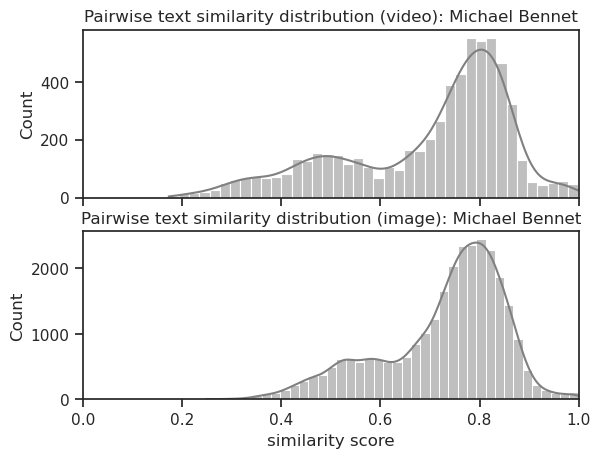

In [8]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(bennet_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(bennet_img, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Michael Bennet', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (image): Michael Bennet', xlabel='similarity score')

In [9]:
# Adam Schiff
schiff_vid = compute_pairwise_similarity(pdid_cid_media_map, 'pd-109092142462587-3', 'video')
schiff_img = compute_pairwise_similarity(pdid_cid_media_map, "pd-109092142462587-3", 'image')

[Text(0.5, 1.0, 'Pairwise text similarity distribution (image): Adam Schiff'),
 Text(0.5, 0, 'similarity score')]

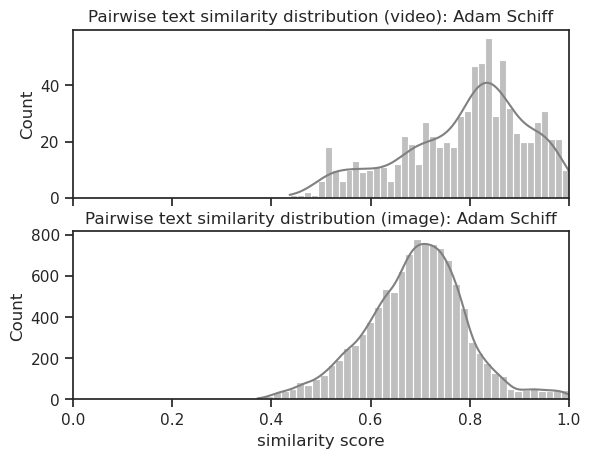

In [11]:
sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(schiff_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(schiff_img, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Adam Schiff', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (image): Adam Schiff', xlabel='similarity score')

[Text(0.5, 1.0, 'Pairwise text similarity distribution (image): Mark Kelly'),
 Text(0.5, 0, 'similarity score')]

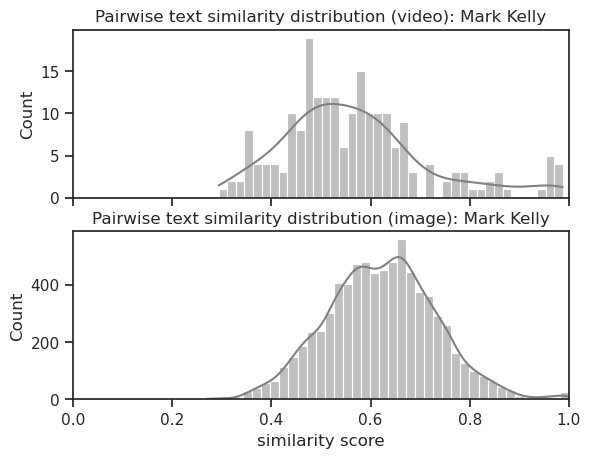

In [13]:
# Mark Kelly 
mkelly_vid = compute_pairwise_similarity(pdid_cid_media_map, 'pd-163148530407080-2', 'video')
mkelly_img = compute_pairwise_similarity(pdid_cid_media_map, "pd-163148530407080-2", 'image')

sns.set_theme(style='ticks', palette="tab10")

fig, ax = plt.subplots(2, sharex=True)

sns.histplot(mkelly_vid, kde=True, bins=40, color='gray', ax=ax[0])
sns.histplot(mkelly_img, kde=True, bins=40, color='gray', ax=ax[1])

ax[0].set_xlim(0, 1)
ax[1].set_xlim(0, 1)


ax[0].set(title='Pairwise text similarity distribution (video): Mark Kelly', xlabel='similarity score')
ax[1].set(title='Pairwise text similarity distribution (image): Mark Kelly', xlabel='similarity score')

In [77]:
rogers_iv = compute_pairwise_similarity(pdid_cid_media_map, 'pd-15351475322-6', 'image, video')

(0.0, 1.0)

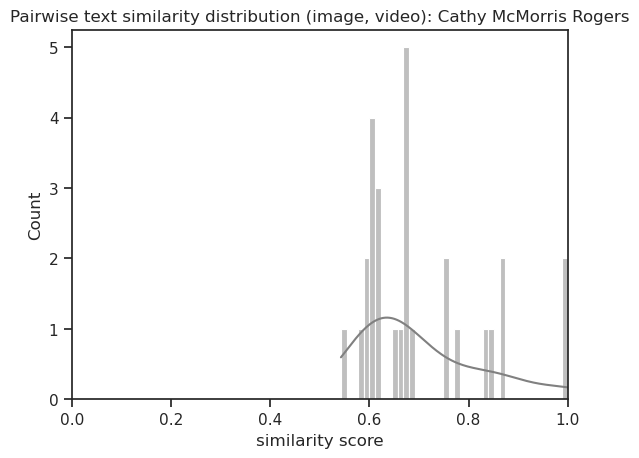

In [79]:
fig, ax = plt.subplots()

sns.histplot(rogers_iv, kde=True, bins=40, color='gray', ax=ax)

ax.set(title='Pairwise text similarity distribution (image, video): Cathy McMorris Rogers', xlabel='similarity score')

ax.set_xlim(0, 1)

In [156]:
def compute_pairwise_similarity_multisponsors(df):
    
    all_scores = {}   

    for row_id in df.index:
        
        curr_pdid = df.loc[row_id, 'pd_id']
        
        curr_sponsor = var[var.pd_id == curr_pdid].disclaimer.iloc[0]
        
        all_scores[curr_sponsor] = []
        
        curr_cid_list = df.loc[row_id, 'cid'].split()
        
        pairs = list(itertools.combinations(curr_cid_list, 2))

        if pairs:
            scores = []
            for pair in pairs: 
                cid1, cid2 = pair
                idx1 = int(cid1.lstrip('cid_'))
                idx2 = int(cid2.lstrip('cid_'))

                score = util.cos_sim(corpus_embeddings[idx1], corpus_embeddings[idx2])[0][0].numpy()
                scores.append(float(score))
        
        all_scores[curr_sponsor].append(scores)
    
    return all_scores

1106      Alexandria Ocasio-Cortez for Congress
1107      Alexandria Ocasio-Cortez for Congress
1108      Alexandria Ocasio-Cortez for Congress
1109      Alexandria Ocasio-Cortez for Congress
1110      Alexandria Ocasio-Cortez for Congress
                          ...                  
123556    Alexandria Ocasio-Cortez for Congress
123557    Alexandria Ocasio-Cortez for Congress
123811    Alexandria Ocasio-Cortez for Congress
123812    Alexandria Ocasio-Cortez for Congress
123813    Alexandria Ocasio-Cortez for Congress
Name: disclaimer, Length: 2495, dtype: object